### 套件和函式導入

In [51]:
import pandas as pd
from hdbcli import dbapi
from datetime import datetime, timedelta
import time
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta 
import os 
import math

In [52]:
def open_so_data(Lead_time=2):
    all_results_2 = pd.DataFrame()

    # 遍历 YM 序列
    for ym_date in full_date_range:
        # 计算 version_date
        version_date = ym_date - pd.DateOffset(months=Lead_time)

        # 构建查询条件
        query_str = f'VERSION == "{version_date.strftime("%Y/%m/01")}" and YM == "{ym_date.strftime("%Y/%m/01")}"'
        # print(query_str)
        # 查询 DataFrame
        result = open_so_ori.query(query_str)
        
        all_results_2 = pd.concat([all_results_2, result])

    # 重置索引（可选）
    all_results_2.reset_index(drop=True, inplace=True)


    merged_open_data = pd.merge(item_class, all_results_2, on='PART_NO', how='inner')
    Region_open_data_2=merged_open_data.query("SHIP_PLANT.str.startswith(@Region_class)")

    selected_so_data_2=Region_open_data_2[['COMPANY_ID','SHIP_PLANT','PD','MODEL','PART_NO','YM','OPEN_QTY']]

    company_so_2 = selected_so_data_2.groupby(['COMPANY_ID','YM','PD','MODEL','PART_NO'])['OPEN_QTY'].sum().reset_index()
    

    return company_so_2


'''
這一部分計算方向指標勝率
'''
def Direction_win_rate(indicator_select=0):

    # 控制so 比較對象
    #indicator_select=0
    so_timeframe=indicator_select+1 
    

    # 方向指標勝率

    trend_indicator=pd.DataFrame()
    trend_indicator["Time"]=Indicator[indicator_select]['Date']
    trend_indicator["Change_rate"]=Indicator[indicator_select]['Indicator']
    # trend_indicator.head()



    so_datachange_rate=pd.DataFrame()
    so_datachange_rate["Time"]=so_info.year_month.shift(so_timeframe)#so_partno_time_series.year_month- pd.DateOffset(months=2)
    so_datachange_rate["Change_rate"]=(((so_info['ORDER_QTY']-so_info['ORDER_QTY'].shift(so_timeframe))/so_info['ORDER_QTY'].shift(so_timeframe))*100).fillna(0)
    so_datachange_rate = so_datachange_rate.dropna(subset=["Time", "Change_rate"])

    # 合併兩個 DataFrame，根據 Time 欄位對齊
    comparred_df = pd.merge(trend_indicator, so_datachange_rate, on='Time', how='outer', suffixes=('_indicator', '_historical'))

    comparred_df = comparred_df.iloc[2:, :].dropna()


    # 檢查兩個欄位之間的方向是否一致
    comparred_df['direction_consistent'] = (
        ((comparred_df['Change_rate_indicator'] > 0) & (comparred_df['Change_rate_historical'] > 0)) | 
        ((comparred_df['Change_rate_indicator'] < 0) & (comparred_df['Change_rate_historical'] < 0)) |
        ((comparred_df['Change_rate_indicator'] == 0) & (comparred_df['Change_rate_historical'] == 0))
    )
    # comparred_df.head()

    # 計算 direction_consistent 為 True 的數量
    true_count = comparred_df['direction_consistent'].sum()
    print("方向指標總數: ",len(comparred_df))
    print(f"方向指標一致的總數: {true_count}")

    print("方向勝率:", true_count/len(comparred_df)*100)


In [53]:
def plot_so_trend(Model_openso, Model_openso_2, so_info, trend_labels):   
    '''
    這張圖是在說所有客戶同料號的情況
    '''
    plt.figure(figsize=(10, 6))
    # plt.plot(open_so_info['YM'], open_so_info['OPEN_QTY'], label=f'{model_name} and {PART_NO_name} in open_So by 2 month (shift)', marker='o',color='orange')

    '''
    open_data time series
    '''
    plt.plot(Model_openso['YM'], Model_openso['OPEN_QTY'], label=f' {PART_NO_name} in open_So by 1 month (shift)', marker='o',color='orange')

    plt.plot(Model_openso_2['YM'], Model_openso_2['OPEN_QTY'], label=f'{PART_NO_name} in open_So by 2 month (shift)', marker='o',color='pink')

    # plt.plot(Model_openso_3['YM'], Model_openso_3['OPEN_QTY'], label=f'{model_name} and {PART_NO_name} in open_So by 3 month (shift)', marker='o',color='brown')


    # plt.plot(opendata_info['YM'], opendata_info['Trend'], label=f'{model_name} and {PART_NO_name} in open_So action at thrat month ', marker='o',color='green')

    '''
    so_data time series
    '''
    plt.plot(so_info['Date'], so_info['ORDER_QTY'], label=f' {PART_NO_name} in So', marker='x',color='blue')

    # plt.plot(so_info['Date'], so_info['2_month_avg'], label=f' {PART_NO_name} in So', marker='x',color='green')
    # plt.plot(so_partno_time_series['year_month'], so_partno_time_series['3_month_avg'], label=f'{model_name} and {PART_NO_name} in So (MA3)', marker='x',color='purple')


    ''' 
    時序誤差量
    '''
    openso_so_diff=Model_openso['OPEN_QTY']-so_info['ORDER_QTY']
    # # 標準化
    openso_so_diff_normal=(openso_so_diff-openso_so_diff.mean())/openso_so_diff.std()
    # plt.bar(so_info['year_month'], openso_so_diff_normal, label=f'{model_name} Normalize Diff openso-so ', alpha=0.3, width=20 ,color='black')


    # plt.bar(so_info['year_month'], openso_so_diff, label=f'{model_name} Diff openso-so ', alpha=0.3, width=20 ,color='green')
    # plt.bar(diff_so_openso["Date"], diff_so_openso["Diff"], label=f'{model_name} Diff openso-so ', alpha=0.3, width=20 ,color='green')

    ''' 
    open_so 指標
    '''
    plt.bar(trend_labels['Date'], trend_labels['labels']*10, label='trend_labels' , alpha=0.3, width=20 ,color='black')
    # plt.bar(Indicator[0]['Date'], Indicator[0]['Indicator']*0.05, label='Indicator one ', alpha=0.3, width=20 ,color='red')

    # plt.bar(Indicator[1]['Date'], Indicator[1]['Indicator']*0.05, label=' Indicator two ', alpha=0.3, width=20 ,color='green')

    # 添加标签和标题
    plt.xlabel('Date')
    plt.ylabel('Value')
    # plt.title(f'MODEL_{model} Comparison between so  and open_so')
    plt.legend()


### 資料導入

In [54]:
so_ori=pd.read_csv('Dataset\So_Data.csv')
product_ori=pd.read_csv('Dataset\Product_Data.csv')
open_so_ori=pd.read_csv('Dataset\open_so_ori.csv')

start_date="2018-01-01"
end_date="2024-08-01"

In [55]:
# 生成時間範圍內的日期
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')  # 'MS'表示每月的開始


In [56]:
product_ori

,PART_NO,PG,PD,PDL,PLM_STATUS,ABC_INDICATOR,MODEL
0,ADAM-6066-D,IAG,iSensing Devices,ADM6,A,A1,ADAM-6066
1,EKI-2541M-BE,ICWG,Industrial Communication,EKIF,A,B1,EKI-2541M
2,SFP-GSS-40KRX-LC,ICWG,Industrial Communication,EKIF,A,C5,808-38724
3,AIMB-588R-00A1,ECG,AIMB,ISUM,A,C2,AIMB-588
4,AMAX-5074-A,IAG,Automation Control,APX5,A,C1,AMAX-5074
...,...,...,...,...,...,...,...
5635,HPC-8212SE-80RB1,ESG,Industrial Servers,AISR,A,C1,HPC-8212
5636,SKY7632LP06A1R-ES,ESG,SKY Server,SKSV,A,C2,SKY-7632
5637,PCA-6120P12-0A3E,ISG,IPC,IPCB,A,C2,PCA-6120P12
5638,SQR-UD4N8G2K6SEBCB,IPSG,Industrial Storage,SQRM,A,C5,SQR-UD4N


In [57]:
product_ori.PART_NO.nunique()

5640

In [58]:
PG_class=['ECG', 'IPSG','IDSG'] #IIOT->4['ISG','IAG','ICWG','ESG'] EIOT->3 ['ECG', 'IPSG','IDSG']

ABC_class='A' # A or B or C

Region_class='CN' # C:China, TW:Taiwan, EU , US

# 檔案存取格式
if 'ECG' in PG_class:
    PG='EIOT'
else:
    PG='IIOT'


#篩選條件
item_class=product_ori.query("ABC_INDICATOR.str.startswith(@ABC_class)  and PG in @PG_class")

# 根據PART_NO 合併
merged_data = pd.merge(item_class, so_ori, on='PART_NO', how='inner')

# 找出A類該區的所有資料
Region_info=merged_data.query("SHIP_PLANT.str.startswith(@Region_class)")

Region_info.loc[:,'Required_date']= pd.to_datetime(Region_info['REQUIRED_DATE'])

#新增月頻的欄位
Region_info.loc[:, 'year_month']=Region_info['Required_date'].dt.to_period('M')

C:\Users\mt.yang\AppData\Local\Temp\ipykernel_21176\3061219310.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Region_info.loc[:,'Required_date']= pd.to_datetime(Region_info['REQUIRED_DATE'])
C:\Users\mt.yang\AppData\Local\Temp\ipykernel_21176\3061219310.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Region_info.loc[:, 'year_month']=Region_info['Required_date'].dt.to_period('M')


In [59]:
selected_data= Region_info[['COMPANY_ID','SHIP_PLANT','PD','MODEL','PART_NO','year_month','REQUIRED_DATE','ORDER_QTY']]

selected_data['year_month']=selected_data['year_month'].dt.to_timestamp()
selected_data.head()

C:\Users\mt.yang\AppData\Local\Temp\ipykernel_21176\316043234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['year_month']=selected_data['year_month'].dt.to_timestamp()


,COMPANY_ID,SHIP_PLANT,PD,MODEL,PART_NO,year_month,REQUIRED_DATE,ORDER_QTY
3,C200131,CNH1,ESBC,MIOE-PWR2,MIOE-PWR2-00A1E,2019-03-01,2019/03/25,26
4,C200131,CNH1,ESBC,MIOE-PWR2,MIOE-PWR2-00A1E,2021-11-01,2021/11/09,40
5,C109390,CNH1,ESBC,MIOE-PWR2,MIOE-PWR2-00A1E,2019-11-01,2019/11/28,5
12,C400032,CNH1,ESBC,MIOE-PWR2,MIOE-PWR2-00A1E,2019-05-01,2019/05/13,1
16,C200987,CNH1,ESBC,MIOE-PWR2,MIOE-PWR2-00A1E,2023-10-01,2023/10/27,90


In [60]:
len(selected_data)

6176

In [61]:
selected_data.SHIP_PLANT.unique()

array(['CNH1', 'CNH3', 'CNH7'], dtype=object)

In [62]:
select_columns=['COMPANY_ID','year_month','PD','MODEL','PART_NO']
company_partno_monthly = selected_data.groupby(select_columns)['ORDER_QTY'].sum().reset_index()
company_partno_monthly.head()

,COMPANY_ID,year_month,PD,MODEL,PART_NO,ORDER_QTY
0,C100008,2016-05-01,Industrial Storage,SQF-S25 830,SQF-S25M8-512G-SAC,1
1,C100008,2016-06-01,Industrial Storage,SQF-S25 830,SQF-S25M8-512G-SAC,6
2,C100008,2016-07-01,Industrial Storage,SQF-S25 830,SQF-S25M8-512G-SAC,3
3,C100008,2016-08-01,Industrial Storage,SQF-S25 830,SQF-S25M8-256G-SAC,1
4,C100008,2016-08-01,Industrial Storage,SQF-S25 830,SQF-S25M8-512G-SAC,1


In [63]:
company_partno_monthly.groupby(['PD'])['ORDER_QTY'].sum().reset_index()

,PD,ORDER_QTY
0,AIMB,74959
1,EBC,19718
2,ESBC,18858
3,Industrial Storage,48969
4,Industrial Wireless,17


### 資料時間

In [64]:
full_date_range = pd.date_range(start=start_date,
                          end=end_date,
                          freq='MS').normalize() 

### open_so 版本資料導入

In [65]:
def fiilna(data_name, date_name='year_month', date_range=full_date_range, QTY_name= 'ORDER_QTY' ):
    ''' 
    填補歷史so日期
    '''
    # 使用 reindex 根據完整的日期範圍來補全缺失的日期
    data_name= data_name.set_index(date_name).reindex(full_date_range).reset_index()



    # 將列名 'index' 重新命名為 'year_month'
    data_name.rename(columns={'index': date_name}, inplace=True)


    # 使用 fillna 填充缺失的 ORDER_QTY 為 0
    min=data_name[QTY_name].min()

    # 計算 OPEN_QTY 欄位中 NaN 值的數量
    # nan_count = open_so_info['OPEN_QTY'].isna().sum()

    # # 顯示 NaN 的數量
    # print(f"OPEN_QTY 欄位中 NaN 的數量：{nan_count}")
    
    data_name[QTY_name] = data_name[QTY_name].fillna(0) # min

    return data_name


company_so=open_so_data(Lead_time=1)
company_so_2=open_so_data(Lead_time=2)
company_so_3=open_so_data(Lead_time=3)

In [77]:
company_so_2

,COMPANY_ID,YM,PD,MODEL,PART_NO,OPEN_QTY
0,C100008,2018-09-01,Industrial Storage,SQF-S25 830,SQF-S25M8-512G-SAC,150.0
1,C100008,2019-09-01,Industrial Storage,SQF-S25 830,SQF-S25M8-512G-SAC,100.0
2,C100008,2020-05-01,Industrial Storage,SQF-S25 830,SQF-S25M8-512G-SAC,244.0
3,C100008,2020-06-01,Industrial Storage,SQF-S25 830,SQF-S25M8-512G-SAC,133.0
4,C100026,2018-07-01,ESBC,MIOE-PWR2,MIOE-PWR2-00A1E,11.0
...,...,...,...,...,...,...
666,C403758,2023-01-01,AIMB,AIMB-505,AIMB-505G2-00A1E,100.0
667,C403758,2024-02-01,AIMB,AIMB-505,AIMB-505G2-00A1E,50.0
668,C403758,2024-03-01,AIMB,AIMB-505,AIMB-505G2-00A1E,50.0
669,C403758,2024-04-01,AIMB,AIMB-505,AIMB-505G2-00A1E,100.0


In [68]:
# 初始化一個新的 DataFrame 用來記錄時間範圍內的統計
data = pd.DataFrame()
data['Date'] = date_range  # 使用指定的時間範圍
data['count'] = 0  # 初始化所有日期的累積計數為 0

### PD 篩選Part_no

In [158]:
PD_name='iSensing Devices' #Panel PC
data_partno=(selected_data.query('PD==@PD_name').groupby(['PART_NO'])['ORDER_QTY'].sum()).nlargest(20)
data_partno.reset_index().PART_NO.unique()

array(['BB-485LDRC9', 'BB-485SD9TB', 'BB-USOPTL4', 'BB-485SD9R',
       'ADAM-6052-D', 'ADAM-6066-D', 'ADAM-6017-D', 'ADAM-4520-F',
       'ADAM-4561-CE', 'ADAM-6060-D1', 'ADAM-6050-D1', 'ADAM-6217-B',
       'ADAM-6051-D', 'ADAM-4017+-F', 'ADAM-4117-C', 'ADAM-5017-A4E',
       'ADAM-4051-C', 'ADAM-4055-C', 'ADAM-4118-C', 'ADAM-4018+-F'],
      dtype=object)

In [126]:
PART_NO_name='ICR-2431'

In [127]:
so_info=company_partno_monthly.query('PD==@PD_name  and PART_NO==@PART_NO_name and  @start_date< year_month < "2024-08-01"').groupby(['year_month'])['ORDER_QTY'].sum().reset_index()


In [128]:
#open part
company_so['YM'] = pd.to_datetime(company_so['YM'], format='%Y/%m/%d')
Model_openso=company_so.query('PD==@PD_name  and PART_NO==@PART_NO_name and  @start_date< YM < "2024-08-01"').groupby(['YM'])['OPEN_QTY'].sum().reset_index()


#open part (2 month ago information)
company_so_2['YM'] = pd.to_datetime(company_so_2['YM'], format='%Y/%m/%d')
Model_openso_2=company_so_2.query('PD==@PD_name  and PART_NO==@PART_NO_name and  @start_date< YM < "2024-08-01"').groupby(['YM'])['OPEN_QTY'].sum().reset_index()

#open part (2 month ago information)
company_so_3['YM'] = pd.to_datetime(company_so_3['YM'], format='%Y/%m/%d')
Model_openso_3=company_so_3.query('PD==@PD_name  and PART_NO==@PART_NO_name and  @start_date< YM < "2024-08-01"').groupby(['YM'])['OPEN_QTY'].sum().reset_index()

In [130]:
'''
填補輸入和輸出 
'''

so_info=fiilna(so_info, date_name='year_month', date_range=full_date_range , QTY_name= 'ORDER_QTY' )

#so先補完才開始算
so_info['2_month_avg'] = so_info['ORDER_QTY'].rolling(window=2).mean()

Model_openso=fiilna(Model_openso, date_name='YM', date_range=full_date_range , QTY_name= 'OPEN_QTY' )

Model_openso_2=fiilna(Model_openso_2, date_name='YM', date_range=full_date_range , QTY_name= 'OPEN_QTY' )

Model_openso_3=fiilna(Model_openso_3, date_name='YM', date_range=full_date_range , QTY_name= 'OPEN_QTY' )

In [131]:
'''
指標設計條件  
'''

indicator_1= ((Model_openso['OPEN_QTY']-Model_openso['OPEN_QTY'].shift(1))/Model_openso['OPEN_QTY'].shift(1)*100).fillna(0)

indicator_2= ((Model_openso_2['OPEN_QTY']-Model_openso_2['OPEN_QTY'].shift(2))/Model_openso['OPEN_QTY'].shift(2)*100).fillna(0)

indicator_3= ((Model_openso_3['OPEN_QTY']-Model_openso_3['OPEN_QTY'].shift(3))/Model_openso['OPEN_QTY'].shift(3)*100).fillna(0)

Indicator = [pd.DataFrame() for _ in range(3)]

Indicator[0]['Date']=Model_openso.YM- pd.DateOffset(months=1)
Indicator[0]['Indicator']=indicator_1

Indicator[1]['Date']=Model_openso_2.YM- pd.DateOffset(months=2)
Indicator[1]['Indicator']=indicator_2

Indicator[2]['Date']=Model_openso_3.YM- pd.DateOffset(months=3)
Indicator[2]['Indicator']=indicator_3

In [132]:
'''
方向指標設定趨勢指標條件  
'''
Indicator_selection=pd.merge(Indicator[0], Indicator[1], on='Date', how='inner', suffixes=('_0', '_1'))
Indicator_selection.head

# 條件設定
conditions = [
    (Indicator_selection['Indicator_0'] > 0) & (Indicator_selection['Indicator_1'] > 0),  # 同時大於0
    (Indicator_selection['Indicator_0'] < 0) & (Indicator_selection['Indicator_1'] < 0)   # 同時小於0
]

# 給予對應的標籤值
choices = [1, -1]

# 使用 np.select 根據條件給予標籤，其他情況標籤為 0
labels = np.select(conditions, choices, default=0)

trend_labels=pd.DataFrame()
trend_labels['Date']=Indicator_selection['Date']
trend_labels['labels']=labels
trend_labels.head()

,Date,labels
0,2017-12-01,0
1,2018-01-01,0
2,2018-02-01,0
3,2018-03-01,0
4,2018-04-01,0


In [133]:
historical_info=pd.DataFrame()
historical_info['Date']=so_info['year_month']- pd.DateOffset(months=2)
historical_info['labels'] = np.where(so_info['ORDER_QTY'].shift(2) <so_info['2_month_avg'], 1, -1)
historical_info.head()

,Date,labels
0,2017-11-01,-1
1,2017-12-01,-1
2,2018-01-01,-1
3,2018-02-01,-1
4,2018-03-01,-1


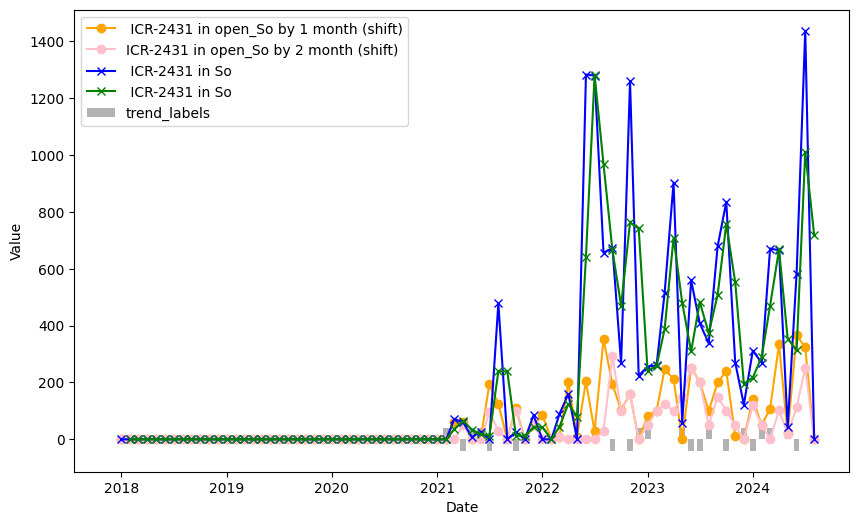

In [134]:
'''
這張圖是在說所有客戶同料號的情況
'''
plt.figure(figsize=(10, 6))
# plt.plot(open_so_info['YM'], open_so_info['OPEN_QTY'], label=f'{model_name} and {PART_NO_name} in open_So by 2 month (shift)', marker='o',color='orange')

'''
open_data time series
'''
plt.plot(Model_openso['YM'], Model_openso['OPEN_QTY'], label=f' {PART_NO_name} in open_So by 1 month (shift)', marker='o',color='orange')

plt.plot(Model_openso_2['YM'], Model_openso_2['OPEN_QTY'], label=f'{PART_NO_name} in open_So by 2 month (shift)', marker='o',color='pink')

# plt.plot(Model_openso_3['YM'], Model_openso_3['OPEN_QTY'], label=f'{model_name} and {PART_NO_name} in open_So by 3 month (shift)', marker='o',color='brown')


# plt.plot(opendata_info['YM'], opendata_info['Trend'], label=f'{model_name} and {PART_NO_name} in open_So action at thrat month ', marker='o',color='green')

'''
so_data time series
'''
plt.plot(so_info['year_month'], so_info['ORDER_QTY'], label=f' {PART_NO_name} in So', marker='x',color='blue')

plt.plot(so_info['year_month'], so_info['2_month_avg'], label=f' {PART_NO_name} in So', marker='x',color='green')
# plt.plot(so_partno_time_series['year_month'], so_partno_time_series['3_month_avg'], label=f'{model_name} and {PART_NO_name} in So (MA3)', marker='x',color='purple')


''' 
時序誤差量
'''
openso_so_diff=Model_openso['OPEN_QTY']-so_info['ORDER_QTY']
# # 標準化
openso_so_diff_normal=(openso_so_diff-openso_so_diff.mean())/openso_so_diff.std()
# plt.bar(so_info['year_month'], openso_so_diff_normal, label=f'{model_name} Normalize Diff openso-so ', alpha=0.3, width=20 ,color='black')


# plt.bar(so_info['year_month'], openso_so_diff, label=f'{model_name} Diff openso-so ', alpha=0.3, width=20 ,color='green')
# plt.bar(diff_so_openso["Date"], diff_so_openso["Diff"], label=f'{model_name} Diff openso-so ', alpha=0.3, width=20 ,color='green')

''' 
open_so 指標
'''
plt.bar(trend_labels['Date'], trend_labels['labels']*40, label='trend_labels' , alpha=0.3, width=20 ,color='black')
# plt.bar(Indicator[0]['Date'], Indicator[0]['Indicator']*0.05, label=f'{model_name} in KA open_So leading ', alpha=0.3, width=20 ,color='black')

# plt.bar(Indicator[1]['Date'], Indicator[1]['Indicator']*0.05, label=f'{model_name} in KA open_So leading ', alpha=0.3, width=20 ,color='green')

# 添加标签和标题
plt.xlabel('Date')
plt.ylabel('Value')
# plt.title(f'MODEL_{model} Comparison between so  and open_so')
plt.legend()

In [135]:
historical_info=pd.DataFrame()
historical_info['Date']=so_info['year_month']- pd.DateOffset(months=2)
historical_info['labels'] = np.where(so_info['ORDER_QTY'].shift(2) <so_info['2_month_avg'], 1, -1)
historical_info.head()

,Date,labels
0,2017-11-01,-1
1,2017-12-01,-1
2,2018-01-01,-1
3,2018-02-01,-1
4,2018-03-01,-1


In [136]:
so_info[30:]

,year_month,ORDER_QTY,2_month_avg
30,2020-07-01,0.0,0.0
31,2020-08-01,0.0,0.0
32,2020-09-01,0.0,0.0
33,2020-10-01,0.0,0.0
34,2020-11-01,0.0,0.0
35,2020-12-01,0.0,0.0
36,2021-01-01,0.0,0.0
37,2021-02-01,0.0,0.0
38,2021-03-01,71.0,35.5
39,2021-04-01,60.0,65.5


In [137]:
'''
驗證趨勢指標& 實際情形是否一致 
'''

trend_compare=pd.merge(trend_labels, historical_info, on='Date', how='inner', suffixes=('_indicator', '_historical'))
trend_compare_sleected=trend_compare[trend_compare['labels_indicator']!=0].copy()

# 判斷兩個欄位是否相同
trend_compare_sleected.loc[:, 'same_labels'] = (trend_compare_sleected['labels_indicator'] == trend_compare_sleected['labels_historical'])
trend_compare_sleected.head()

,Date,labels_indicator,labels_historical,same_labels
38,2021-02-01,1,1,True
40,2021-04-01,-1,-1,True
41,2021-05-01,1,1,True
42,2021-06-01,1,1,True
43,2021-07-01,-1,1,False


In [138]:
trend_compare_sleected

,Date,labels_indicator,labels_historical,same_labels
38,2021-02-01,1,1,True
40,2021-04-01,-1,-1,True
41,2021-05-01,1,1,True
42,2021-06-01,1,1,True
43,2021-07-01,-1,1,False
46,2021-10-01,-1,1,False
55,2022-07-01,1,-1,False
57,2022-09-01,-1,1,False
59,2022-11-01,-1,-1,True
60,2022-12-01,1,1,True


In [139]:
pos_indicator=(trend_compare_sleected['labels_indicator'] == 1).sum()
pos_indicator

12

In [140]:
tp_num=((trend_compare_sleected['labels_indicator'] == 1) & (trend_compare_sleected['same_labels'] == True)).sum()
tp_num

10

In [141]:
neg_indicator=(trend_compare_sleected['labels_indicator'] == -1).sum()
neg_indicator

10

In [142]:
tn_num=((trend_compare_sleected['labels_indicator'] == -1) & (trend_compare_sleected['same_labels'] == True)).sum()
tn_num

4

In [143]:
tp_rate=(tp_num/pos_indicator)*100
tp_rate

83.33333333333334

In [144]:
tp_rate=(tn_num/neg_indicator)*100
tp_rate

40.0

In [123]:
print('指標總數',len(trend_compare_sleected))
print('趨勢指標勝率',(trend_compare_sleected['same_labels'].sum()/len(trend_compare_sleected))*100)

指標總數 23
趨勢指標勝率 73.91304347826086


### 自動化多顆料號

In [69]:
company_partno_monthly.PD.unique()

array(['Industrial Storage', 'EBC', 'AIMB', 'ESBC', 'Industrial Wireless'],
      dtype=object)

In [70]:
PD_name='AIMB' #Panel PC AIMB
data_partno=(selected_data.query('PD==@PD_name').groupby(['PART_NO'])['ORDER_QTY'].sum()).nlargest(25)
data_partno.reset_index().PART_NO.unique()

array(['AIMB-505G2-00A1E', 'AIMB-215D-S6B2', 'AIMB-R431F-21A1E'],
      dtype=object)

In [71]:
# open(one month) format: YM OPEN_QTY
Model_openso

# open(two month)   format: YM OPEN_QTY
Model_openso_2


Increment_one_month=pd.DataFrame()
Increment_one_month['Date']=so_info['Date']
Increment_one_month['SO_QTY']=so_info['ORDER_QTY']
Increment_one_month['Backlog_one']=Model_openso['OPEN_QTY']
Increment_one_month['Backlog_two']=Model_openso_2['OPEN_QTY']

Increment_one_month

,Date,SO_QTY,Backlog_one,Backlog_two
0,2018-01-01,0.0,0.0,0.0
1,2018-02-01,0.0,0.0,0.0
2,2018-03-01,0.0,0.0,0.0
3,2018-04-01,0.0,0.0,0.0
4,2018-05-01,0.0,0.0,0.0
...,...,...,...,...
75,2024-04-01,0.0,0.0,0.0
76,2024-05-01,0.0,0.0,0.0
77,2024-06-01,0.0,0.0,0.0
78,2024-07-01,0.0,0.0,0.0


In [113]:
diff=so_info['ORDER_QTY']-Model_openso['OPEN_QTY']
diff.describe()


count     80.000000
mean      -6.512500
std       52.271442
min     -213.000000
25%      -15.250000
50%        3.000000
75%       17.250000
max      112.000000
dtype: float64

In [28]:
import seaborn as sns

In [36]:
# import matplotlib.pyplot as plt


# # 畫出直方圖和核密度估計
# plt.figure(figsize=(10, 6))
# sns.histplot(diff, kde=True, bins=30)  # kde=True 用來畫出核密度估計
# plt.title("Difference Distribution with KDE")
# plt.xlabel("Difference (ORDER_QTY - OPEN_QTY)")
# plt.ylabel("Frequency")
# plt.show()


***************************
Part_no:  AIMB-505G2-00A1E
指標總數:  23
趨勢指標勝率:  73.91304347826086
向上指標數:  14
項商為正且為正 8
TP ratio:  57.14285714285714
向下指標數:  9
TN ratio:  100.0
方向指標總數:  78
方向指標一致的總數: 54
方向勝率: 69.23076923076923
方向指標總數:  78
方向指標一致的總數: 33
方向勝率: 42.30769230769231
Final result
料號總數 1
所有指標總數: 23
向上指標總數 14
向下指標總數 9
TP rate 57.14285714285714
TN rate 100.0
Total 此PD勝率 73.91304347826086


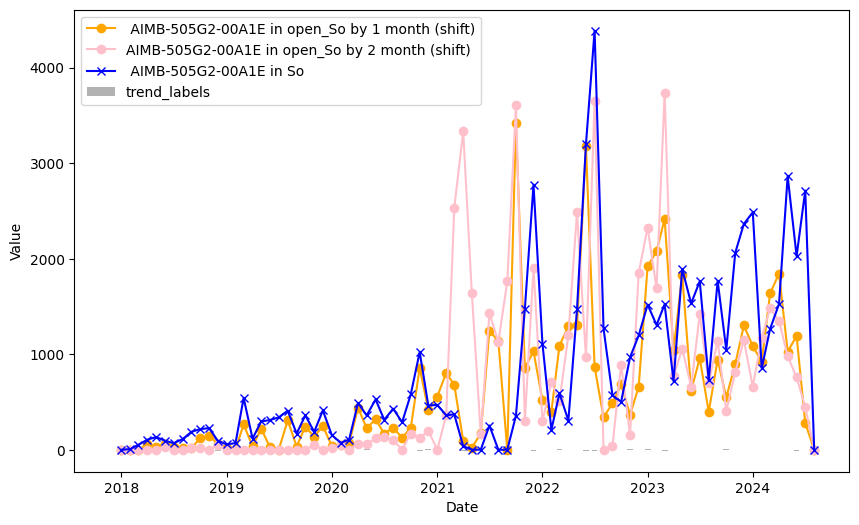

In [74]:

total_num,correct_num, part_number=0, 0, 0
total_up_num, total_down_num, total_tp_num, total_tn_num= 0,0,0,0

threshold=30
for PART_NO_name in ['AIMB-505G2-00A1E']:#data_partno.reset_index().PART_NO.unique().tolist():

    
    #so part
    so_info=company_partno_monthly.query('PD==@PD_name  and PART_NO==@PART_NO_name and  @start_date< year_month < "2024-08-01"').groupby(['year_month'])['ORDER_QTY'].sum().reset_index()
   
    #open part
    company_so['YM'] = pd.to_datetime(company_so['YM'], format='%Y/%m/%d')
    Model_openso=company_so.query('PD==@PD_name  and PART_NO==@PART_NO_name and  @start_date< YM < "2024-08-01"').groupby(['YM'])['OPEN_QTY'].sum().reset_index()


    #open part (2 month ago information)
    company_so_2['YM'] = pd.to_datetime(company_so_2['YM'], format='%Y/%m/%d')
    Model_openso_2=company_so_2.query('PD==@PD_name  and PART_NO==@PART_NO_name and  @start_date< YM < "2024-08-01"').groupby(['YM'])['OPEN_QTY'].sum().reset_index()

    #open part (3 month ago information)
    company_so_3['YM'] = pd.to_datetime(company_so_3['YM'], format='%Y/%m/%d')
    Model_openso_3=company_so_3.query('PD==@PD_name  and PART_NO==@PART_NO_name and  @start_date< YM < "2024-08-01"').groupby(['YM'])['OPEN_QTY'].sum().reset_index()


    '''
    填補so & openso
    '''

    so_info=fiilna(so_info, date_name='year_month', date_range=full_date_range , QTY_name= 'ORDER_QTY' )

    Model_openso=fiilna(Model_openso, date_name='YM', date_range=full_date_range , QTY_name= 'OPEN_QTY' )

    Model_openso_2=fiilna(Model_openso_2, date_name='YM', date_range=full_date_range , QTY_name= 'OPEN_QTY' )

    Model_openso_3=fiilna(Model_openso_3, date_name='YM', date_range=full_date_range , QTY_name= 'OPEN_QTY' )

    #用於驗證兩個月後需求量基準值
    so_info['2_month_avg'] = so_info['ORDER_QTY'].rolling(window=2).mean()
    

    '''
    指標設計條件  
    '''

    indicator_1= ((Model_openso['OPEN_QTY']-Model_openso['OPEN_QTY'].shift(1))/Model_openso['OPEN_QTY'].shift(1)*100).fillna(0)

    # indicator_2= ((Model_openso_2['OPEN_QTY']-Model_openso['OPEN_QTY'].shift(2))/Model_openso['OPEN_QTY'].shift(2)*100).fillna(0)
    indicator_2= ((Model_openso_2['OPEN_QTY']-Model_openso_2['OPEN_QTY'].shift(2))/Model_openso_2['OPEN_QTY'].shift(2)*100).fillna(0)

    indicator_3= ((Model_openso_3['OPEN_QTY']-Model_openso_3['OPEN_QTY'].shift(3))/Model_openso['OPEN_QTY'].shift(3)*100).fillna(0)

    Indicator = [pd.DataFrame() for _ in range(3)]

    Indicator[0]['Date']=Model_openso.YM- pd.DateOffset(months=1)
    Indicator[0]['Indicator']=indicator_1

    Indicator[1]['Date']=Model_openso_2.YM- pd.DateOffset(months=2)
    Indicator[1]['Indicator']=indicator_2

    Indicator[2]['Date']=Model_openso_3.YM- pd.DateOffset(months=3)
    Indicator[2]['Indicator']=indicator_3



    '''
    方向指標設定趨勢指標條件  
    '''
    # 合并前两个 DataFrame
    Indicator_selection = pd.merge(Indicator[0], Indicator[1], on='Date', how='inner', suffixes=('_0', '_1'))


    # 條件設定
    conditions = [
        (Indicator_selection['Indicator_0'] > 0) & (Indicator_selection['Indicator_1'] > 30) & (Indicator_selection['Indicator_1'] > Indicator_selection['Indicator_0']),#(Indicator_selection['Indicator_0'] > Indicator_selection['Indicator_0'].shift(2)),  # 同時大於0
        (Indicator_selection['Indicator_0'] < 0) & (Indicator_selection['Indicator_1'] < -50 ) &(Indicator_selection['Indicator_1'] < Indicator_selection['Indicator_0'])  # 同時小於0
    ]

    # 給予對應的標籤值
    choices = [1, -1]

    # 使用 np.select 根據條件給予標籤，其他情況標籤為 0
    labels = np.select(conditions, choices, default=0)

    # 指標dataframe 
    trend_labels=pd.DataFrame()
    trend_labels['Date']=Indicator_selection['Date']
    trend_labels['labels']=labels
    trend_labels.head()
    # 歷史資料 dataframe 
    historical_info=pd.DataFrame()
    historical_info['Date']=so_info['year_month']- pd.DateOffset(months=2)
    historical_info['labels'] = np.where(so_info['ORDER_QTY'].shift(2) <so_info['2_month_avg'], 1, -1)
    historical_info.head()


    '''
    驗證趨勢指標& 實際情形是否一致 
    '''

    trend_compare=pd.merge(trend_labels, historical_info, on='Date', how='inner', suffixes=('_indicator', '_historical'))
    # 忽略=0 盤整情況
    trend_compare_sleected=trend_compare[trend_compare['labels_indicator']!=0].copy()

    # 判斷兩個欄位是否相同
    trend_compare_sleected.loc[:, 'same_labels'] = trend_compare_sleected['labels_indicator'] == trend_compare_sleected['labels_historical']

    # 指標為正的數量
    pos_indicator=(trend_compare_sleected['labels_indicator'] == 1).sum()
    # 指標為正真為正的數量
    tp_num=((trend_compare_sleected['labels_indicator'] == 1) & (trend_compare_sleected['same_labels'] == True)).sum()
    tp_rate=(tp_num/pos_indicator)*100
    # 指標為負的數量
    neg_indicator=(trend_compare_sleected['labels_indicator'] == -1).sum()
    # 指標為負真為負的數量
    tn_num=((trend_compare_sleected['labels_indicator'] == -1) & (trend_compare_sleected['same_labels'] == True)).sum()
    tn_rate=(tn_num/neg_indicator)*100


    print('***************************')
    print('Part_no: ', PART_NO_name)
    print('指標總數: ',len(trend_compare_sleected))
    print('趨勢指標勝率: ',(trend_compare_sleected['same_labels'].sum()/len(trend_compare_sleected))*100)
    print("向上指標數: ", pos_indicator)
    print('項商為正且為正',tp_num)
    print("TP ratio: ", tp_rate)
    print("向下指標數: ", neg_indicator)
    print("TN ratio: ", tn_rate)

    # backlog( version=t-1)
    Direction_win_rate(indicator_select=0)
    # backlog( version=t-2)
    Direction_win_rate(indicator_select=1)

    '''
    存取資料info  
    '''
    so_info=so_info.rename(columns={'year_month': 'Date'})
    data_output=pd.merge(so_info, trend_labels, on='Date', how='outer').dropna(subset=['ORDER_QTY']).fillna(0)
    # 加入基本資訊
    data_output.insert(0, 'PG_Class', PG)
    data_output.insert(1, 'Ship_Plant', Region_class)
    data_output.insert(2, 'PD', PD_name)
    data_output.insert(3, 'PART_NO', PART_NO_name)
    data_output.drop(columns=['2_month_avg'], inplace=True)

    # file_path = r'C:\Users\mt.yang\Desktop\SCM_Indicator\EIOT_AB_AIMB_EBC(B).csv' #'SCN_Indicator.csv'

    # # 如果文件不存在，寫入數據並添加標題; 如果文件存在，則追加數據並不寫入標題
    # if not os.path.exists(file_path):
    #     data_output.to_csv(file_path, mode='w', header=True, index=False)
    # else:
    #     data_output.to_csv(file_path, mode='a', header=False, index=False)



    # 將資料存成csv
    data_to_save = pd.DataFrame({
    'PART_NO': [PART_NO_name],  # 料號
    'Upward_num': [pos_indicator],  # 向上指標數
    'Downward_num': [neg_indicator],  # 向下指標數
    'TP_ratio_up': [round(tp_rate, 2)],  # 向上TP ratio
    'TN_ratio_down': [round(tn_rate, 2)],  # 向下TP ratio

    })
    # 將 DataFrame 寫入 CSV 檔案，指定檔名
    
    # file_path = 'Indicator_Confusion_matrix.csv'

    # # 如果文件不存在，寫入數據並添加標題; 如果文件存在，則追加數據並不寫入標題
    # if not os.path.exists(file_path):
    #     data_to_save.to_csv(file_path, mode='w', header=True, index=False)
    # else:
    #     data_to_save.to_csv(file_path, mode='a', header=False, index=False)



    # 總數統計
    total_num+=len(trend_compare_sleected) # 指標數統計
    correct_num+=trend_compare_sleected['same_labels'].sum()
    part_number+=1 # 料號總數統計
    total_up_num+=pos_indicator
    total_down_num+=neg_indicator
    total_tp_num+=tp_num
    total_tn_num+=tn_num

    '''
    觀察backlog 值大於Order QTY 情況  
    '''
    # comparision=pd.DataFrame()
    # comparision['Date']=so_info['Date']
    # comparision['Backlog_one']=Model_openso['OPEN_QTY']
    # comparision['QTY']=so_info['ORDER_QTY']
    # comparision

    # # 遍歷 comparision，當 Backlog_one > QTY 時，對應的日期加 1
    # for index, row in comparision.iterrows():
    #     if row['Backlog_one'] > row['QTY']+threshold:
    #         # 根據日期找到相應的 row 並進行累加
    #         data.loc[data['Date'] == row['Date'], 'count'] += 1



    '''
    這部分是計算增加量
    '''
    # Increment_one_month=pd.DataFrame()
    # Increment_one_month['Date']=so_info['Date']
    # Increment_one_month['SO_QTY']=so_info['ORDER_QTY']
    # Increment_one_month['Backlog_one']=Model_openso['OPEN_QTY']
    # # Increment_one_month['Backlog_two']=Model_openso_2['OPEN_QTY']
    # diff=so_info['ORDER_QTY']-Model_openso['OPEN_QTY']

    # print(diff.describe())

    # # 輸出經過標準化
    # diff=(diff-diff.mean())/diff.std()
    # Increment_one_month['diff']= diff
    
    # # 畫出直方圖和核密度估計   
    # plt.figure(figsize=(10, 6))
    # sns.histplot(diff, kde=True, bins=30)  # kde=True 用來畫出核密度估計
    # plt.title("Difference Distribution with KDE")
    # plt.xlabel("Difference (ORDER_QTY - OPEN_QTY)")
    # plt.ylabel("Frequency")
    # plt.show()

    # 計算偏態（Skewness）
    # diff_skewness = diff.skew()
    # print("偏態 (Skewness):", diff_skewness)

    # # 計算峰度（Kurtosis）
    # diff_kurtosis = diff.kurtosis()
    # print("峰度 (Kurtosis):", diff_kurtosis)

    '''
    畫指標和so圖 
    '''
    plot_so_trend(Model_openso, Model_openso_2, so_info, trend_labels)



print("Final result")
print('料號總數', part_number)
print('所有指標總數:',total_num)
print('向上指標總數', total_up_num)
print('向下指標總數', total_down_num)
print('TP rate', (total_tp_num/total_up_num)*100)
print('TN rate', (total_tn_num/total_down_num)*100)
print('Total 此PD勝率', (correct_num/total_num)*100)

    

In [78]:
Model_openso_2

,YM,OPEN_QTY
0,2018-01-01,0.0
1,2018-02-01,0.0
2,2018-03-01,0.0
3,2018-04-01,1.0
4,2018-05-01,0.0
...,...,...
75,2024-04-01,1350.0
76,2024-05-01,980.0
77,2024-06-01,757.0
78,2024-07-01,449.0


In [76]:
Indicator_selection

,Date,Indicator_0,Indicator_1
0,2017-12-01,0.000000,0.000000
1,2018-01-01,0.000000,0.000000
2,2018-02-01,0.000000,inf
3,2018-03-01,inf,0.000000
4,2018-04-01,-44.067797,2900.000000
...,...,...,...
74,2024-02-01,77.440347,14.991482
75,2024-03-01,12.775061,-33.828494
76,2024-04-01,-44.336043,-43.925926
77,2024-05-01,15.968841,-54.183673


In [75]:
trend_labels

,Date,labels
0,2017-12-01,0
1,2018-01-01,0
2,2018-02-01,0
3,2018-03-01,0
4,2018-04-01,0
...,...,...
74,2024-02-01,0
75,2024-03-01,0
76,2024-04-01,0
77,2024-05-01,0


In [118]:
Increment_one_month

,Date,SO_QTY,Backlog_one,Backlog_two,diff
0,2018-01-01,0.0,0.0,0.0,0.124590
1,2018-02-01,0.0,0.0,0.0,0.124590
2,2018-03-01,7.0,7.0,0.0,0.124590
3,2018-04-01,2.0,2.0,0.0,0.124590
4,2018-05-01,2.0,0.0,0.0,0.162852
...,...,...,...,...,...
75,2024-04-01,91.0,73.0,30.0,0.468946
76,2024-05-01,103.0,113.0,90.0,-0.066719
77,2024-06-01,100.0,33.0,30.0,1.406361
78,2024-07-01,31.0,106.0,30.0,-1.310228


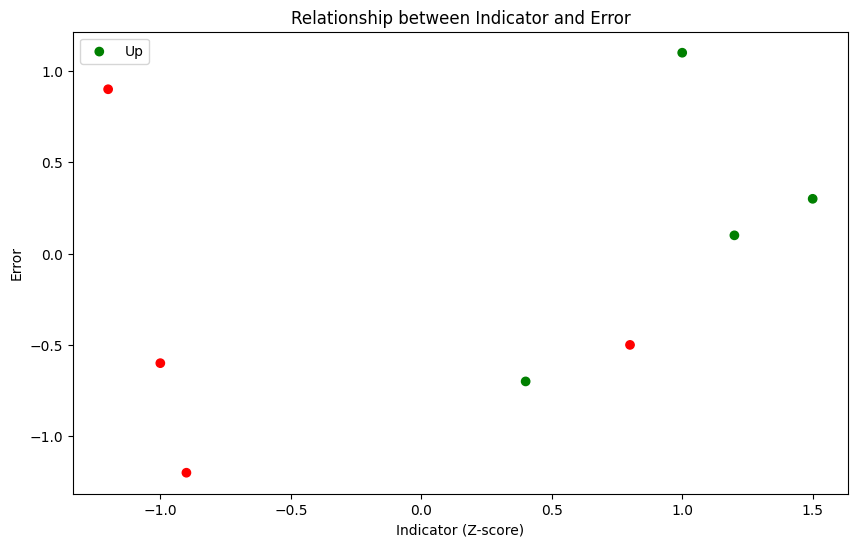

In [116]:
import matplotlib.pyplot as plt
import pandas as pd

# 示例數據
data = {
    'Indicator': [1.2, 0.8, 1.5, -0.9, -1.2, 0.4, 1.0, -1.0],
    'Error': [0.1, -0.5, 0.3, -1.2, 0.9, -0.7, 1.1, -0.6],
    'Trend': ['up', 'down', 'up', 'down', 'down', 'up', 'up', 'down']
}

df = pd.DataFrame(data)

# 顏色區分「向上」和「向下」
colors = {'up': 'green', 'down': 'red'}

# 散點圖
plt.figure(figsize=(10, 6))
plt.scatter(df['Indicator'], df['Error'], c=df['Trend'].map(colors), label=df['Trend'])

# 加標籤和標題
plt.title('Relationship between Indicator and Error')
plt.xlabel('Indicator (Z-score)')
plt.ylabel('Error')
plt.legend(['Up', 'Down'], loc='upper left')

plt.show()


In [62]:
Indicator_selection.query('Date>= "2022-11-01"')

,Date,Indicator_0,Indicator_1
59,2022-11-01,0.000000,inf
60,2022-12-01,inf,inf
61,2023-01-01,-50.000000,-62.500000
62,2023-02-01,-50.000000,-100.000000
63,2023-03-01,66.666667,1600.000000
64,2023-04-01,920.000000,0.000000
65,2023-05-01,-100.000000,-100.000000
66,2023-06-01,0.000000,0.000000
67,2023-07-01,inf,inf
68,2023-08-01,0.000000,0.000000


In [18]:
trend_compare_sleecteicator_selection

,Date,labels_indicator,labels_historical,same_labels
44,2021-08-01,1,-1,False
46,2021-10-01,-1,-1,True
48,2021-12-01,1,1,True
50,2022-02-01,-1,-1,True
52,2022-04-01,1,1,True
54,2022-06-01,-1,1,False
55,2022-07-01,1,-1,False
57,2022-09-01,-1,-1,True
59,2022-11-01,1,1,True
60,2022-12-01,1,1,True


In [35]:
trend_labels

,Date,labels
0,2017-12-01,0
1,2018-01-01,0
2,2018-02-01,0
3,2018-03-01,0
4,2018-04-01,0
...,...,...
74,2024-02-01,1
75,2024-03-01,1
76,2024-04-01,0
77,2024-05-01,-1


         Date  Demand  Signal
0  2023-01-31     100       0
1  2023-02-28     120       1
2  2023-03-31     110      -1
3  2023-04-30     130       1
4  2023-05-31     140       1
5  2023-06-30     125      -1
6  2023-07-31     150       1
7  2023-08-31     160       1
8  2023-09-30     155      -1
9  2023-10-31     170       1
10 2023-11-30     165      -1
11 2023-12-31     180       1


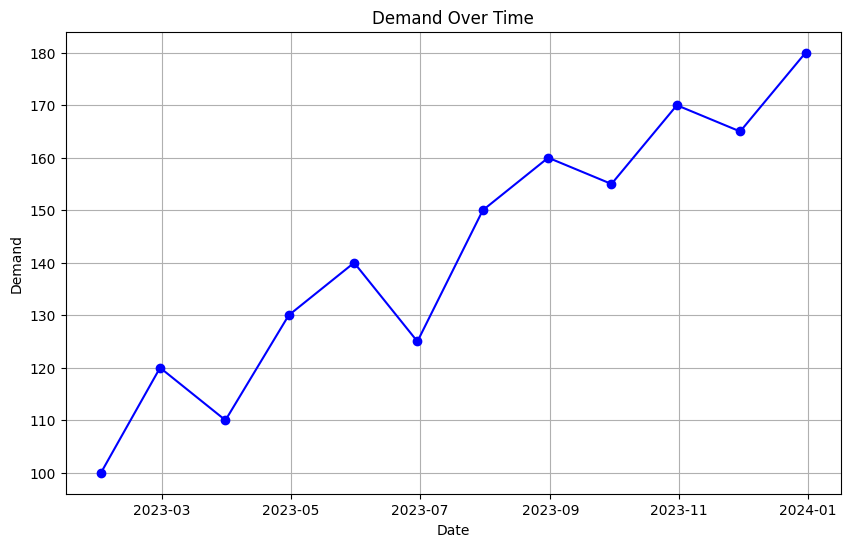

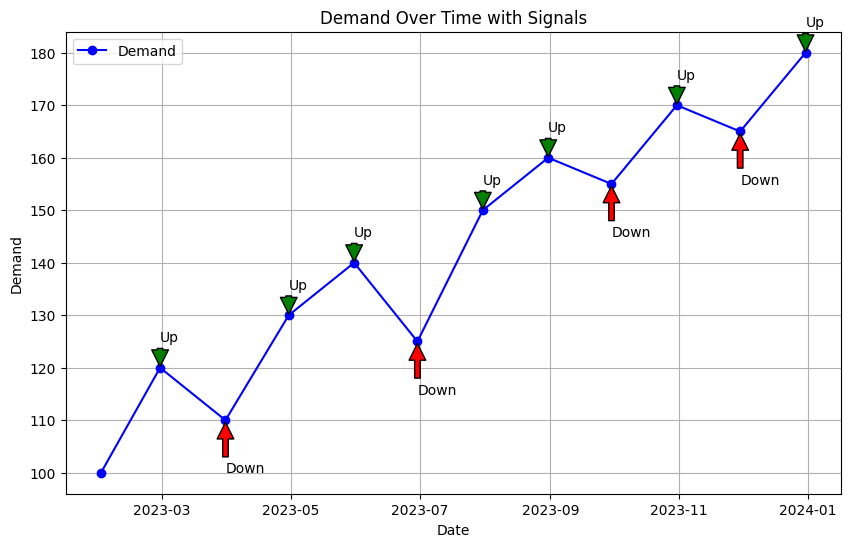

In [78]:
import matplotlib.pyplot as plt
import pandas as pd

# 模擬數據
data = {
    'Date': pd.date_range(start='2023-01-01', periods=12, freq='M'),
    'Demand': [100, 120, 110, 130, 140, 125, 150, 160, 155, 170, 165, 180]
}

df = pd.DataFrame(data)

# 繪製需求折線圖
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Demand'], marker='o', color='blue', label='Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Demand Over Time')
plt.grid(True)


# 計算需求變化：1 表示上升，-1 表示下降，0 表示沒有變化
df['Signal'] = df['Demand'].diff().apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# 查看結果
print(df)



# 繪製需求折線圖
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Demand'], marker='o', color='blue', label='Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Demand Over Time with Signals')
plt.grid(True)

# 在對應的點上添加上升或下降的標示
for i in range(1, len(df)):
    if df['Signal'][i] == 1:
        # 上升訊號，向上箭頭
        plt.annotate('Up', xy=(df['Date'][i], df['Demand'][i]), xytext=(df['Date'][i], df['Demand'][i] + 5),
                     arrowprops=dict(facecolor='green', shrink=0.05))
    elif df['Signal'][i] == -1:
        # 下降訊號，向下箭頭
        plt.annotate('Down', xy=(df['Date'][i], df['Demand'][i]), xytext=(df['Date'][i], df['Demand'][i] - 10),
                     arrowprops=dict(facecolor='red', shrink=0.05))

# 顯示圖例
plt.legend()
plt.show()


In [1046]:
data_to_save 

,PG_Class,Ship_Plant,PD_Name,PART_NO,Upward_num,Downward_num,TP_ratio_up,TN_ratio_down
0,EIOT,US,Industrial Storage,SQF-S25M8-1T-SAC,1,6,0.0,50.0


In [793]:

regin_data[Region_class]=data['count'] 
regin_data

,Date,C,TW,EU,US
0,2018-01-01,0,0,0,0
1,2018-02-01,0,0,0,0
2,2018-03-01,0,0,0,0
3,2018-04-01,0,0,0,0
4,2018-05-01,0,0,0,0
...,...,...,...,...,...
75,2024-04-01,4,5,2,0
76,2024-05-01,1,2,2,0
77,2024-06-01,0,6,0,1
78,2024-07-01,1,4,0,1


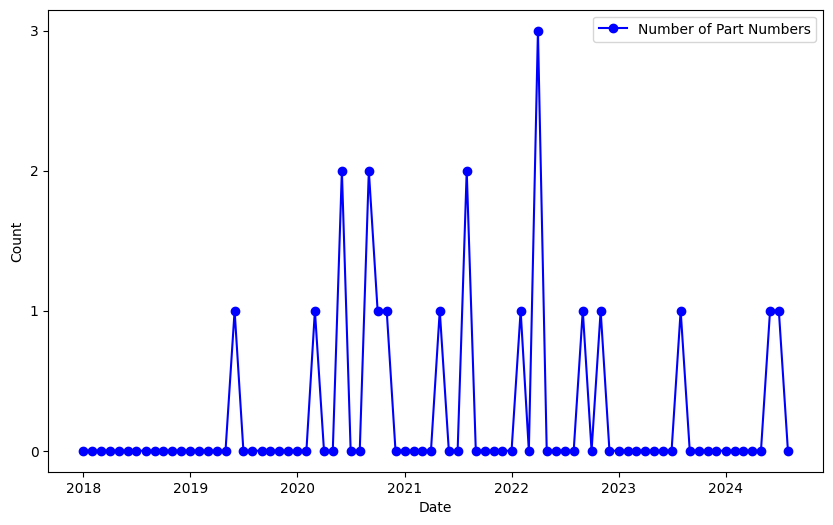

In [794]:
import matplotlib.ticker as ticker
plt.figure(figsize=(10, 6))

plt.plot(data['Date'], data['count'], label='Number of Part Numbers', marker='o',color='blue')
# plt.plot(regin_data['Date'], regin_data['C'], label='Number of Part Numbers', marker='o',color='blue')

# 添加标签和标题
plt.xlabel('Date')
plt.ylabel('Count')
# 設定 y 軸顯示整數
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()

In [795]:
regin_data['sum']=regin_data['C']+ regin_data['TW'] + regin_data['EU']+ regin_data['US']
regin_data

,Date,C,TW,EU,US,sum
0,2018-01-01,0,0,0,0,0
1,2018-02-01,0,0,0,0,0
2,2018-03-01,0,0,0,0,0
3,2018-04-01,0,0,0,0,0
4,2018-05-01,0,0,0,0,0
...,...,...,...,...,...,...
75,2024-04-01,4,5,2,0,11
76,2024-05-01,1,2,2,0,5
77,2024-06-01,0,6,0,1,7
78,2024-07-01,1,4,0,1,6


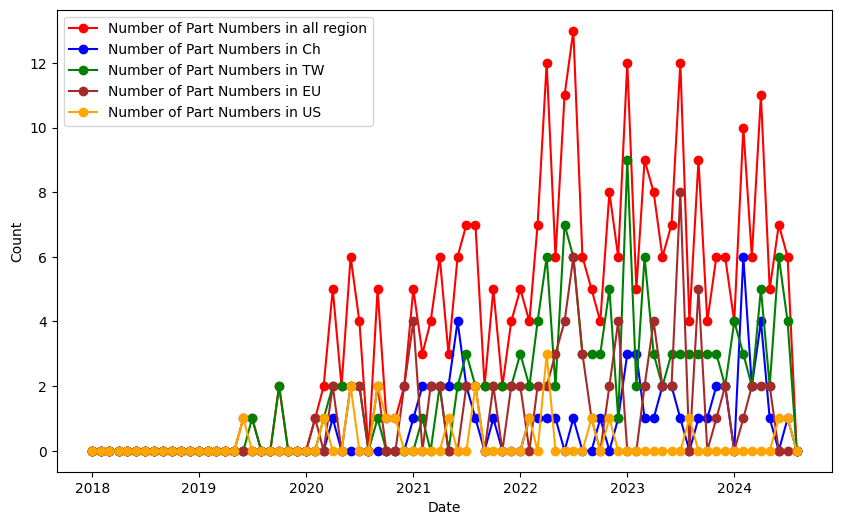

In [798]:
import matplotlib.ticker as ticker
plt.figure(figsize=(10, 6))

# plt.plot(data['Date'], data['count'], label='Number of Part Numbers', marker='o',color='blue')
plt.plot(regin_data['Date'], regin_data['sum'], label='Number of Part Numbers in all region', marker='o',color='red')

plt.plot(regin_data['Date'], regin_data['C'], label='Number of Part Numbers in Ch', marker='o',color='blue')

plt.plot(regin_data['Date'], regin_data['TW'], label='Number of Part Numbers in TW', marker='o',color='green')

plt.plot(regin_data['Date'], regin_data['EU'], label='Number of Part Numbers in EU', marker='o',color='brown')

plt.plot(regin_data['Date'], regin_data['US'], label='Number of Part Numbers in US', marker='o',color='orange')
# 添加标签和标题
plt.xlabel('Date')
plt.ylabel('Count')
# 設定 y 軸顯示整數
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()